In [1]:
import argparse
import torch
from numpy import dot
from numpy.linalg import norm
import wandb
import numpy as np
from dassl.utils import setup_logger, set_random_seed, collect_env_info
from dassl.config import get_cfg_default
from dassl.engine import build_trainer
from sklearn.mixture import BayesianGaussianMixture
from scipy.linalg import sqrtm
from scipy.stats import chi2
from scipy.spatial.distance import cdist

In [2]:
def reset_cfg(cfg, args):
    if args.root:
        cfg.DATASET.ROOT = args.root

    if args.output_dir:
        cfg.OUTPUT_DIR = args.output_dir

    if args.resume:
        cfg.RESUME = args.resume

    if args.seed:
        cfg.SEED = args.seed

    if args.source_domains:
        cfg.DATASET.SOURCE_DOMAINS = args.source_domains

    if args.target_domains:
        cfg.DATASET.TARGET_DOMAINS = args.target_domains

    if args.transforms:
        cfg.INPUT.TRANSFORMS = args.transforms

    if args.trainer:
        cfg.TRAINER.NAME = args.trainer

    if args.backbone:
        cfg.MODEL.BACKBONE.NAME = args.backbone

    if args.head:
        cfg.MODEL.HEAD.NAME = args.head

    #if args.uncertainty:
    cfg.MODEL.UNCERTAINTY = args.uncertainty

    #if args.pos:
    cfg.MODEL.POS = args.pos
    
    cfg.TRAINER.CONSTSTYLE.TYPE = 'ver5'
    
def setup_cfg(args):
    cfg = get_cfg_default()
    reset_cfg(cfg, args)
    if args.dataset_config_file:
        cfg.merge_from_file(args.dataset_config_file)
    if args.config_file:
        cfg.merge_from_file(args.config_file)
    cfg.merge_from_list(args.opts)
    cfg.freeze()
    return cfg

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--root', type=str, default='./DATA', help='path to dataset')
parser.add_argument(
    '--output-dir', type=str, default='../output/dg/pacs/baseline/verify2/cartoon', help='output directory'
)
parser.add_argument(
    '--resume',
    type=str,
    default='',
    help='checkpoint directory (from which the training resumes)'
)
parser.add_argument(
    '--seed',
    type=int,
    default=1,
    help='only positive value enables a fixed seed'
)
parser.add_argument(
    '--source-domains',
    type=str,
    nargs='+',
    default='cartoon'.split(),
    help='source domains for DA/DG'
)
parser.add_argument(
    '--target-domains',
    type=str,
    nargs='+',
    default=['sketch'],
    help='target domains for DA/DG'
)
parser.add_argument(
    '--transforms', type=str, nargs='+', help='data augmentation methods'
)
parser.add_argument(
    '--config-file', type=str, default='../configs/trainers/dg/vanilla/pacs.yaml', help='path to config file'
)
parser.add_argument(
    '--dataset-config-file',
    type=str,
    default='../configs/datasets/dg/pacs.yaml',
    help='path to config file for dataset setup'
)
parser.add_argument(
    '--trainer', type=str, default='Vanilla', help='name of trainer'
)
parser.add_argument(
    '--backbone', type=str, default='', help='name of CNN backbone'
)
parser.add_argument('--head', type=str, default='', help='name of head')
parser.add_argument(
    '--eval-only', action='store_true', help='evaluation only'
)
parser.add_argument(
    '--model-dir',
    type=str,
    default='',
    help='load model from this directory for eval-only mode'
)
parser.add_argument(
    '--load-epoch',
    type=int,
    help='load model weights at this epoch for evaluation'
)
parser.add_argument(
    '--no-train', action='store_true', help='do not call trainer.train()'
)
parser.add_argument(
    'opts',
    default=None,
    nargs=argparse.REMAINDER,
    help='modify config options using the command-line'
)
parser.add_argument('--uncertainty', default=0.0, type=float)
parser.add_argument('--pos', nargs='+', type=int, default=[],
                    help='pos for uncertainty')
parser.add_argument('--wandb', default=0, type=int, help='visualize on Wandb')
parser.add_argument('--option', default='', type=str, help='additional options')
parser.add_argument('--update_interval', default=20, type=int, help='update cluster interval')

args = parser.parse_args('')

In [4]:
cfg = setup_cfg(args)
if args.wandb:
    if 'u' in cfg.MODEL.BACKBONE.NAME:
        job_type = 'DSU'
    elif 'c' in cfg.MODEL.BACKBONE.NAME:
        job_type = 'ConstStyle'
    else:
        job_type = 'Baseline'
    if cfg.MODEL.BACKBONE.PRETRAINED:
        job_type += '-pretrained'
        
    tracker = wandb.init(
        project = 'StyleDG',
        entity = 'aiotlab',
        config = args,
        group = f'{cfg.DATASET.NAME}',
        name = f'train={cfg.DATASET.SOURCE_DOMAINS}_test={cfg.DATASET.TARGET_DOMAINS}_type={args.option}',
        job_type = job_type
    )
    args.tracker = tracker

if cfg.SEED >= 0:
    print('Setting fixed seed: {}'.format(cfg.SEED))
    set_random_seed(cfg.SEED)
setup_logger(cfg.OUTPUT_DIR)

if torch.cuda.is_available() and cfg.USE_CUDA:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

trainer = build_trainer(cfg, args)
# device = torch.device('cpu')
# trainer.model.backbone.to(device)

Setting fixed seed: 1
Loading trainer: Vanilla
<class 'dassl.engine.dg.vanilla.Vanilla'>
Loading dataset: PACS
Train dataset statistics| Domain [0 1] - count [2107 1499] | Class: [0 1 2 3 4 5 6] - count [520 592 474 288 470 510 752]
Test dataset statistics| Domain [0] - count [2048] | Class: [0 1 2 3 4 5 6] - count [379 255 285 184 201 295 449]
Building transform_train
+ resize to 224x224
+ random flip
+ random translation
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
Building transform_test
+ resize to 224x224
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
***** Dataset statistics *****
  Dataset: PACS
  Source domains: ['cartoon', 'photo']
  Target domains: ['art_painting']
  # classes: 7
  # train_x: 3,606
  # val: 408
  # test: 2,048
Building model
Backbone: resnet18
# params: 11,180,103
Loading evaluator: Classification


In [5]:
trainer.load_model(cfg.OUTPUT_DIR, epoch=100)

Loading weights to model from "../output/dg/pacs/baseline/verify2/cartoon_photo/model/model.pth.tar-100" (epoch = 100)


In [6]:
train_loader = trainer.train_loader_x
test_loader = trainer.test_loader

In [7]:
# id_mean = []
# id_std = []
# id_domains = []
# id_labels = []
# id_feats = []
# train_loader_x = trainer.train_loader_x
# for idx, batch in enumerate(train_loader_x):
#     images, label = trainer.parse_batch_train(batch)
#     domain = batch['domain']
#     style_feat = trainer.model.backbone.stylemaps(images, domain, store_feature=True, apply_conststyle=True)
#     class_feat = trainer.model.backbone.featuremaps(images, domain, store_feature=True, apply_conststyle=True)
#     style_feat = style_feat.detach().cpu().numpy()
#     mean = np.mean(style_feat, axis=(2, 3))
#     std = np.std(style_feat, axis=(2, 3))
#     id_mean.extend(mean)
#     id_std.extend(std)
#     id_domains.extend(domain.numpy())
#     id_labels.extend(label.detach().cpu().numpy())
#     id_feats.extend(class_feat.detach().cpu().numpy())
# total_id_feats = len(id_domains)

In [8]:
id_mean = []
id_std = []
id_domains = []
id_labels = []
id_feats = []
train_loader_x = trainer.train_loader_x
for idx, batch in enumerate(train_loader_x):
    images, label = trainer.parse_batch_train(batch)
    domain = batch['domain']
    style_feat = trainer.model.backbone.stylemaps(images)
    class_feat = trainer.model.backbone.featuremaps(images)
    style_feat = style_feat.detach().cpu().numpy()
    mean = np.mean(style_feat, axis=(2, 3))
    std = np.std(style_feat, axis=(2, 3))
    id_mean.extend(mean)
    id_std.extend(std)
    id_domains.extend(domain.numpy())
    id_labels.extend(label.detach().cpu().numpy())
    id_feats.extend(class_feat.detach().cpu().numpy())
total_id_feats = len(id_domains)

In [9]:
# od_mean = []
# od_std = []
# od_domains = []
# od_labels = []
# od_feats = []
# test_loader = trainer.test_loader
# for idx, batch in enumerate(test_loader):
#     images, label, domain = trainer.parse_batch_train(batch)
#     od_domains.extend([3 for i in range(len(label))])
#     style_feat = trainer.model.backbone.stylemaps(images, domain, store_feature=True, apply_conststyle=True, is_test=True)
#     class_feat = trainer.model.backbone.featuremaps(images, domain, store_feature=True, apply_conststyle=True, is_test=True)
#     style_feat = style_feat.detach().cpu().numpy()
#     mean = np.mean(style_feat, axis=(2, 3))
#     std = np.std(style_feat, axis=(2, 3))
#     od_mean.extend(mean)
#     od_std.extend(std)
#     od_labels.extend(label.detach().cpu().numpy())
#     od_feats.extend(class_feat.detach().cpu().numpy())
# total_od_feats = len(od_domains)

In [10]:
od_mean = []
od_std = []
od_domains = []
od_labels = []
od_feats = []
test_loader = trainer.test_loader
for idx, batch in enumerate(test_loader):
    images, label = trainer.parse_batch_test(batch)
    style_feat = trainer.model.backbone.stylemaps(images)
    class_feat = trainer.model.backbone.featuremaps(images)
    style_feat = style_feat.detach().cpu().numpy()
    mean = np.mean(style_feat, axis=(2, 3))
    std = np.std(style_feat, axis=(2, 3))
    od_mean.extend(mean)
    od_std.extend(std)
    od_domains.extend([3 for i in range(len(label))])
    od_labels.extend(label.detach().cpu().numpy())
    od_feats.extend(class_feat.detach().cpu().numpy())
total_od_feats = len(od_domains)

# for idx, conststyle in enumerate(trainer.model.backbone.conststyle):
#     if idx == 3:
#         od_mean.extend(conststyle.mean)
#         od_std.extend(conststyle.std)

In [11]:
id_domains = np.array(id_domains)
od_domains = np.array(od_domains)
total_domains = np.hstack((id_domains, od_domains))
id_labels = np.array(id_labels)
od_labels = np.array(od_labels)
total_labels = np.hstack((id_labels, od_labels))

In [12]:
od_mean = np.array(od_mean)
od_std = np.array(od_std)
id_mean = np.array(id_mean)
id_std = np.array(id_std)
id_feats = np.array(id_feats)
od_feats = np.array(od_feats)
total_feats = np.vstack((id_feats, od_feats))
total_mean = np.vstack((id_mean, od_mean))
total_std = np.vstack((id_std, od_std))

In [13]:
feats_mean = np.mean(total_feats, axis=(2, 3))
feats_std = np.std(total_feats, axis=(2, 3))

In [14]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE 

In [15]:
# stacked_data = np.hstack((id_mean, id_std))
# bayes_cluster = BayesianGaussianMixture(n_components=10, covariance_type='full', max_iter=200)
# bayes_cluster.fit(stacked_data)

In [16]:
# predicted_labels = bayes_cluster.predict(stacked_data)

In [17]:
tsne_data = np.hstack((total_mean, total_std))
tsne = TSNE(n_components=2)
transformed_data = tsne.fit_transform(tsne_data)

/tmp/ipykernel_2470835/3335614416.py:3: UserWarning: Mismatched number of handles and labels: len(handles) = 3 len(labels) = 4
  plt.legend(handles=scatter.legend_elements()[0], labels=classes)


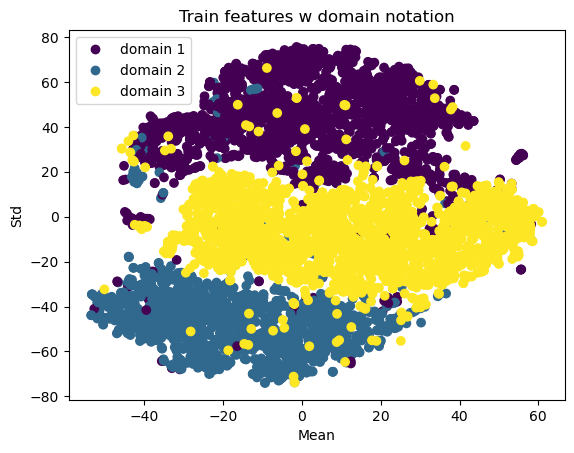

In [18]:
classes = ['domain 1', 'domain 2', 'domain 3', 'out-domain']
scatter = plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=total_domains)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.title('Train features w domain notation')
plt.xlabel('Mean')
plt.ylabel('Std')
plt.show()

In [19]:
total_domains

array([1, 0, 0, ..., 3, 3, 3])

In [20]:
domain_mean, domain_cov = [], []
for i in [0, 1, 3]:
    selected_feats = tsne_data[total_domains == i]
    bayes_cluster = BayesianGaussianMixture(n_components=1, covariance_type='full', max_iter=200)
    bayes_cluster.fit(selected_feats)
    domain_mean.append(bayes_cluster.means_[0])
    domain_cov.append(bayes_cluster.covariances_[0])

In [21]:
# cluster_mean = np.mean([domain_mean[i] for i in range(3)], axis=0)
# cluster_cov = np.mean([domain_cov[i] for i in range(3)], axis=0)

In [22]:
def wasserstein_distance_multivariate(mean1, cov1, mean2, cov2):
    mean_diff = mean1 - mean2
    mean_distance = np.dot(mean_diff, mean_diff)
    sqrt_cov1 = sqrtm(cov1)
    if np.iscomplexobj(sqrt_cov1):
        sqrt_cov1 = sqrt_cov1.real
    # Compute the term involving the covariance matrices
    cov_sqrt_product = sqrtm(sqrt_cov1 @ cov2 @ sqrt_cov1)
    if np.iscomplexobj(cov_sqrt_product):
        cov_sqrt_product = cov_sqrt_product.real

    cov_term = np.trace(cov1 + cov2 - 2 * cov_sqrt_product)
    wasserstein_distance = np.sqrt(mean_distance + cov_term)
    return wasserstein_distance

def mahalanobis_distance(point, mean, cov):
    inv_cov_matrix = np.linalg.inv(cov)
    diff = point - mean
    distance = np.sqrt(np.dot(np.dot(diff, inv_cov_matrix), diff.T))
    if len(distance.shape) > 0:  # Check if distance is an array
        distance = np.diagonal(distance)
    
    return distance

In [23]:
total_distance = 0.0
for i in [0, 1]:
    distance = wasserstein_distance_multivariate(domain_mean[i], domain_cov[i], domain_mean[2], domain_cov[2])
    total_distance += distance

total_distance

1.5394043359248095

In [24]:
# for i in range(4):
#     total_distance = 0.0
#     for j in range(4):
#         if i != j:
#             distance = wasserstein_distance_multivariate(domain_mean[j], domain_cov[j], domain_mean[i], domain_cov[i])
#             total_distance += distance
#             print(f'Distance from domain {i} to domain {j} is {distance}')

In [25]:
# total_distance = 0.0
# for j in range(3):
#         distance = wasserstein_distance_multivariate(domain_mean[j], domain_cov[j], cluster_mean, cluster_cov)
#         total_distance += distance
# print(f'Distance to target domain is {total_distance}')

In [26]:
# selected_feats = tsne_data[total_domains == 2]
# inv_cov = np.linalg.inv(cluster_cov)
# # distance = cdist(selected_feats, [cluster_mean], metric='mahalanobis', VI=inv_cov)
# print('Euclidean distance')
# distance = cdist(selected_feats, [cluster_mean], metric='euclidean')

In [27]:
# np.mean(distance), np.std(distance), np.max(distance), np.min(distance)